In [1]:
import time, os, sys, warnings
import os.path as osp
import numpy as np

%matplotlib inline
from pylab import *
import pydot
import matplotlib.patches as patches

import caffe
from PIL import ImageDraw, Image
import csv
from caffe import layers as L, params as P
from caffe.proto import caffe_pb2
import caffe.draw

from IPython.display import Image, display

import cv2
from PIL import Image
# from easydict import EasyDict as edict
# from easydict import EasyDict

caffe.set_device(1)
caffe.set_mode_gpu()

In [166]:
# get the data loader here

# Helper functions for loading data

def get_cord(txt_loc):
    cord = []
    with open(txt_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        cord_arr = np.zeros(4) 
        for row in reader:
            """
            The below stuff is required if the a$$nuckle who created the bboxes txt file didn't tab delimit 
            but instead used spaces
            """
            if (len(row) == 1):
                row = row[0].split()
            img_class = row[0]
            cord.append(row[0])
            cord_arr[0] = float(row[4])
            cord_arr[1] = float(row[5])
            cord_arr[2] = float(row[6])
            cord_arr[3] = float(row[7])
            cord.append(cord_arr)
            cord_arr = np.zeros(4)
    f.close()
    return cord

def data_loader(path, mode, return_img = False):
    """
    Function to load image locations, corresponding classes and BBoxes contained withing a list file

    return:
    A list with each individual image of the form
    [Image_location in str, Image_Class, BBox in []]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + mode + '.list'
    data = [] 
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        for row in reader:
            # seperate test-case for COCO
            if (path[-5:-1] == 'COCO'):   
                text = row[0][0:5] + '-labels/' + row[0][-16:-3] + 'txt'
            # for VOC and GVDL-D
            else:
                if (mode == 'test'):
                    text = row[0][0:5] + 'labels'+ row[0][11:-3] + 'txt' 
                else:
                    text = row[0][0:6] + 'labels' + row[0][12:-3] + 'txt'
            cord = get_cord(path + text)
            if (return_img == False):
                data.append([path + row[0], cord])
            else:
                print("Demanding images")
                
    """ The following code is to verify the dataloader 
        Please give the index of the image file you want to load; the code will take care of the txt file
        To verify, give a particular index
    """
#     print(len(data))
    return data

In [168]:
# To load the GVDL data
data = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/', 'test', return_img = True)
data

Demanding images
Demanding images
Demanding images
Demanding images
Demanding images
Demanding images
Demanding images
Demanding images
Demanding images
Demanding images


[]

In [2]:
def plot_blobs(net, layer, cols = 5, batchIndex = 0, figsize = (5,5), cmap = cm.get_cmap('viridis'),v=(0,1), byrow = False, idx = -1):
    
    # number of blobs annd their dimensions
    num_channels  = net.blobs[layer].data.shape[1]
    cont_height   = net.blobs[layer].data.shape[2]
    cont_width    = net.blobs[layer].data.shape[3]
    
    if  (not isinstance(idx, list)): idx=range(num_channels)
    num_channels = len(idx)
    
    rows = int(np.ceil(num_channels/cols))
    f, splt = plt.subplots(rows,cols,figsize=figsize)


    for c,curCh in enumerate(idx):
        content = (net.blobs[layer].data[batchIndex, curCh, :, :])
        
        if byrow==False:
            splt[c%rows,int(c/rows)].imshow(content, cmap = cm.get_cmap('viridis', 420),vmin = v[0],vmax=v[1])
        else:
            splt[int(c/rows),c%rows].imshow(content, cmap = cm.get_cmap('viridis', 420),vmin = v[0],vmax=v[1])
        
        
def plot_activation_hist(net, layer, cols = 5, batchIndex = 0, figsize = (5,5), cmap = cm.get_cmap('viridis'),v=(0,1), h=100, idx = -1):

    # number of blobs annd their dimensions
    num_channels  = net.blobs[layer].data.shape[1]
    cont_height   = net.blobs[layer].data.shape[2]
    cont_width    = net.blobs[layer].data.shape[3]
    
    if  (not isinstance(idx, list)): idx=range(num_channels)
    num_channels = len(idx)
    
    rows = int(np.ceil(num_channels/cols))
    f, splt = plt.subplots(rows,cols,figsize=figsize)

    for c,curCh in enumerate(idx):
        
        content = (net.blobs[layer].data[batchIndex, curCh, :, :])
        cc = content.reshape(1024)
        if byrow==False:
            splt[c%rows,int(c/rows)].hist(cc,h)
        else:
            splt[int(c/rows),c%rows].hist(cc,h)

In [3]:
net =  caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.prototxt',
                 '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-512.caffemodel',
                 caffe.TEST)

/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg
(334, 500, 3)
(512, 512, 3)


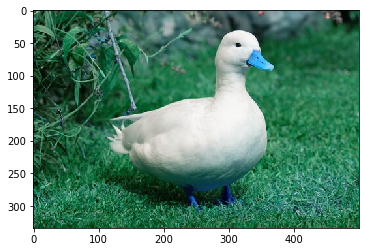

In [12]:
def get_cord(txt_location):
#     img = Image.open(img_location)
    #img = img.resize((512,512))
    with open(txt_location, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')
        cord = []
        cord_arr = np.zeros(4) 
        for row in reader:
            img_class = row[0]
            x_top = float(row[4])
            y_top = float(row[5])
            x_bottom = float(row[6])
            y_bottom = float(row[7])
    return x_top, y_top, x_bottom, y_bottom

def normalized_cord(image, cord):
#     function to normalize the cordinates
    y, x,_ = np.shape(image)
    x_top, y_top, x_bottom, y_bottom = cord
    return x_top/x, y_top/y, x_bottom/x, y_bottom/y

# 	draw = ImageDraw.Draw(img)
# 	draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# 	print (img_class)
# 	img.show()


img_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg'
txt_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.txt'
# x_top, y_top, x_bottom, y_bottom = get_cord(img_name, txt_name)
# img = Image.open(img_name)
# # img = cv2.imread(img_loc,0)
# draw = ImageDraw.Draw(img)
# draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# fig5,ax5 = plt.subplots(1)
# plt.title("GT Boxes")

# for tmpRect in myProposedRects:

# rect = patches.Rectangle(
#         (x_top,y_top),
#         x_bottom - x_top,
#         y_bottom - y_top,
#         linewidth=2,
#         edgecolor='r',
#         facecolor='none')
# ax5.add_patch(rect)

# ax5.imshow(img)

# plt.show()

#image_name='test_images/000456.jpg'
#image_name='test_images/duck512.jpg'
#image_name='test_images/enight.jpg'
# image_name='test_images/wduck.jpg'

im_batch = [img_name] #quick test on one image
num_images = len(im_batch)
processed_ims = []
im_scale_factors = []  #for multiscale processing

for j,im_file  in enumerate(im_batch):
    print(im_file)
    im = cv2.imread(im_file)
    plt.imshow(im)

    # Retype and normilize image
    #-------------------------------------------
    im_orig = im.astype(np.float32, copy=True)
    im_orig /= 255
    im_orig -= .5


    # Get shape and Max and Min of an image
    #-------------------------------------------
    im_shape = im_orig.shape
    print(im_shape)
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    
    target_size = 512
    im_scale = float(target_size) / float(im_size_min)

    #--------------------------------------------------------------
    # Future: multiscale load
    # Prevent the biggest axis from being more than MAX_SIZE
    #if np.round(im_scale * im_size_max) > MAX_SIZE:
    #    im_scale = float(MAX_SIZE) / float(im_size_max)
    #--------------------------------------------------------------
    imW = (im_shape[1])
    imH = (im_shape[0])

    target_size = 512
    im_scaleX = float(target_size) / float(imW)
    im_scaleY = float(target_size) / float(imH)

    im = cv2.resize(im_orig, None, None, fx=im_scaleX, fy=im_scaleY, interpolation=cv2.INTER_LINEAR)

#     im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
    print(im.shape)

    im_scale_factors.append(im_scale)
    
    processed_ims.append(im)

In [13]:
 im_shape

(334, 500, 3)

In [14]:
def loadBatch(net, processed_ims):
    
    num_images = len(processed_ims)
    max_shape = np.array([im.shape for im in processed_ims]).max(axis=0)
    
    # Blob placeholder
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),dtype=np.float32)

    
    # load images into blob placeholder
    #==================================================
    for i in range(num_images):
        im = processed_ims[i]
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im
    

    # Change Channels in Caffe format
    #==================================================
    channel_swap = (0, 3, 1, 2)   # Original    
    blob = blob.transpose(channel_swap)


    im_scales = np.array(im_scale_factors)

    blobs = {'data' : None}
    blobs['data'] = blob
    im_blob = blobs['data']


    # reshape network inputs
    net.blobs['data'].reshape(*(blobs['data'].shape))
    return {'data': blobs['data'].astype(np.float32, copy=False)}

In [15]:
# Forward
blobs_out = net.forward(**loadBatch(net,processed_ims))

(1, 448, 32, 32)
0.0 13.364515


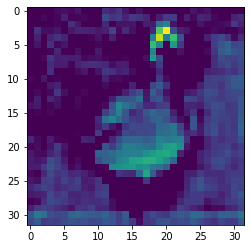

In [16]:
#What does the output looks like
#------------------------------------------------------
mydata = net.blobs['cascade192/output'].data
print(mydata.shape)
output = np.squeeze(mydata[0,0,:,])
plt.imshow(output)

print(np.min(output),np.max(output))

In [105]:
import caffe
net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                 '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                caffe.TEST)

In [106]:
# # load the output from net1 into net3
# img_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg'
# txt_name = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.txt'


# img = Image.open(img_name)

# # This is the vusualization code
# # draw = ImageDraw.Draw(img)
# # draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# # fig1,ax1 = plt.subplots(1)
# # plt.title("GT Boxes")

# # # for tmpRect in myProposedRects:

# # rect = patches.Rectangle(
# #         (x_top,y_top),
# #         x_bottom - x_top,
# #         y_bottom - y_top,
# #         linewidth=2,
# #         edgecolor='r',
# #         facecolor='none')
# # ax1.add_patch(rect)

# # ax1.imshow(img)

# # plt.show()

# print("The original shape of the image is")
# print(np.shape(img))

# print("#" * 100)
# print("resizing the image")

# im_shape = np.shape(img)
# imW = (im_shape[1])
# imH = (im_shape[0])

# target_size = 1      # change to 1 later
# im_scaleX = float(target_size) / float(imW)
# im_scaleY = float(target_size) / float(imH)

# im = cv2.resize(im_orig, None, None, fx=im_scaleX, fy=im_scaleY, interpolation=cv2.INTER_LINEAR)
# print("The new dimensions are")
# print(np.shape(im))
# # fig2,ax2 = plt.subplots(1)
# # plt.title("Resized Image")
# cord = x_top, y_top, x_bottom, y_bottom
# xn_top, yn_top, xn_bottom, yn_bottom = normalized_cord(img,cord)

# # This is the visualization code
# # rect = patches.Rectangle(
# #         (xn_top * target_size,yn_top * target_size),
# #         xn_bottom * target_size - xn_top * target_size,
# #         yn_bottom *target_size - yn_top * target_size,
# #         linewidth=2,
# #         edgecolor='g',
# #         facecolor='none')
# # ax2.add_patch(rect)
# # ax2.imshow(im)
# # plt.show()

In [107]:
x_top, y_top, x_bottom, y_bottom = get_cord(txt_name)
cord = x_top, y_top, x_bottom, y_bottom
img = Image.open(img_name)
target_size = 1
xn_top, yn_top, xn_bottom, yn_bottom = normalized_cord(img,cord)
xn_top*target_size, yn_top*target_size, xn_bottom*target_size, yn_bottom*target_size

(0.22876, 0.09581, 0.73808, 0.897)

In [108]:
# now load data into net3
data_list = []
label_list = [xn_top, yn_top, xn_bottom, yn_bottom, 0]
data_list.append(mydata)
# net3.blobs['data'].reshape(*np.asarray(data_list).shape)
ll = np.asarray(label_list)
ll = np.reshape(ll,(1,1,1,5))
label_list = ll.tolist()
net3.blobs['data'].data[...] = data_list
net3.blobs['bboxes'].data[...] = label_list

In [109]:
class_output = net3.forward()
out =  net3.blobs['global_pool'].data
roi = net3.blobs['roi_pool'].data

In [110]:
net3.blobs['bboxes'].data[...]

array([[[[0.22876, 0.09581, 0.73808, 0.897  , 0.     ]]]], dtype=float32)

In [112]:
np.shape(net3.blobs['roi_pool'].data[...])

(1, 448, 8, 8)

(1, 448, 8, 8)
0.17202953 6.7770844


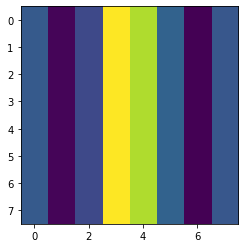

In [113]:
mydata = net3.blobs['roi_pool'].data
print(mydata.shape)
output = np.squeeze(mydata[0,0,:,])
plt.imshow(output)

print(np.min(output),np.max(output))

In [82]:

out_label = class_output
np.shape(out)


(1, 128, 1, 1)

In [83]:
vec = np.reshape(out,(128))
print(vec)

[ 0.17830291  0.07952479 -0.21418741 -0.06227454  0.09372168  0.01521497
 -0.06353392  0.16989416 -0.01325516 -0.05272143  0.08584118  0.17476772
 -0.00894106 -0.08091862  0.08939848 -0.15335613 -0.06764771  0.12384898
  0.22420874 -0.00689631 -0.03766745  0.07829195  0.09173018 -0.12194443
 -0.06959507 -0.00449026  0.1335583  -0.18119629  0.011895   -0.08402536
 -0.15172172  0.31917965  0.079551   -0.21059169  0.0840864   0.12228817
 -0.13395119 -0.15925269 -0.0363506   0.02829336  0.12484621 -0.05402197
  0.11888821  0.2037022   0.01446846  0.0346273   0.08620663 -0.11672539
  0.14610264  0.01926462  0.18347742 -0.03338022  0.08330926  0.07957314
  0.10269584 -0.07703594 -0.02278947  0.03078528 -0.15615223  0.09196898
  0.1194497   0.04133487  0.0722731   0.28092745  0.00185678  0.05666072
 -0.13031515 -0.00964538 -0.06122872 -0.12268905  0.11601829  0.28142655
 -0.1735222   0.05344319  0.28767446 -0.12639852 -0.08095478  0.07436991
 -0.06015088  0.00337189  0.24263953 -0.19069864 -0

In [94]:
def net3(data, txt_file):
    x_top, y_top, x_bottom, y_bottom = get_cord(txt_file)
    cord = x_top, y_top, x_bottom, y_bottom
    img = Image.open(img_name)
    target_size = 1
    xn_top, yn_top, xn_bottom, yn_bottom = normalized_cord(img,cord)
    xn_top*target_size, yn_top*target_size, xn_bottom*target_size, yn_bottom*target_size
    data_list = []
    label_list = [xn_top, yn_top, xn_bottom, yn_bottom, 0]
    data_list.append(mydata)
    # net3.blobs['data'].reshape(*np.asarray(data_list).shape)
    ll = np.asarray(label_list)
    ll = np.reshape(ll,(1,1,1,5))
    label_list = ll.tolist()
    net3 = caffe.Net('/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/complete_model_gorchnet.prototxt',
                 '/opt/caffe/neurala/training-pipeline/models/classifier/complete_model/GorchNet-ROI.caffemodel',
                caffe.TEST)
    net3.blobs['data'].data[...] = data_list
    net3.blobs['bboxes'].data[...] = label_list
    class_output = net3.forward()
    out =  net3.blobs['global_pool'].data
    return out
    
out = net3(mydata, txt_name)

In [95]:
vec = np.reshape(out,(128))
print(vec)

[ 1.68139681e-01  2.33121201e-01  1.26384348e-01 -5.89088500e-02
  4.11682203e-02  2.20284179e-01  1.83470145e-01  1.34981617e-01
  1.34788737e-01  2.39737108e-02 -5.25484569e-02  8.71543214e-02
 -7.35846460e-02 -6.10669442e-02  9.05436724e-02 -4.82168421e-02
 -1.57246977e-01  1.04664668e-01  9.44748893e-02  5.83240762e-05
  1.77080736e-01 -1.12778179e-01 -3.51925083e-02  1.44190580e-01
  1.88883441e-03  8.00492391e-02  4.45671044e-02 -4.87709185e-03
  1.72753900e-01 -1.17625788e-01 -1.25823721e-01  9.69428867e-02
 -2.21166685e-01  4.01069820e-02 -1.29300570e-02 -2.24603534e-01
  1.04673736e-01 -1.41550496e-01 -1.42613977e-01  1.16897918e-01
 -8.26550424e-02  1.04966953e-01 -5.62056750e-02  1.95360500e-02
  3.64081794e-03  6.13303259e-02 -1.89880461e-01  7.38156512e-02
  1.53212026e-01  1.46900326e-01  1.29013896e-01 -1.47685871e-01
  6.95815012e-02  1.96774676e-01  5.23239449e-02 -8.19169655e-02
  2.01359197e-01 -7.99157545e-02  1.00055404e-01 -8.84114951e-02
  1.62154227e-01  6.93668

131


In [120]:
data[0][1]

['squirrel', array([ 84.59589, 235.60592, 465.71729, 362.30111])]